In [3]:
color_demand = 'black'
color_outage = 'lightgray'
color_gridpower = 'red'
color_solar = 'green'
color_batterystate = 'lightseagreen' 
color_batterycharge = 'orchid'
color_batterydischarge = 'blue'
color_junepricing = 'darkorange'
color_decemberpricing = 'brown'

# Case 2

## Power Use Plots

status: optimal
Battery Capacity [MW]:  1826.6666666634105
Minimized Cost: $ 6008629.7865555
Cost of Battery [$]:  1577642.6088084478
Solar Size [kW]:  -5.116366492289951e-05


(0.0, 240.0)

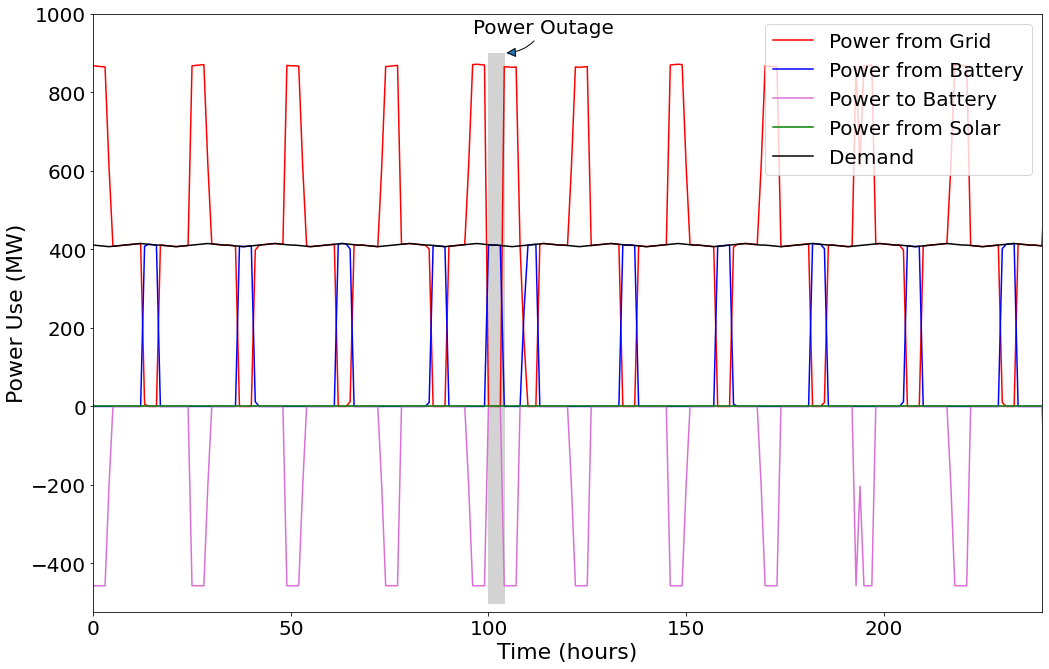

In [28]:
# JUNE 4 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Jun')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 104):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax.plot(range(0,t), P_g.value, color_gridpower, label = 'Power from Grid') 
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery') 
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), P_s*(S_max.value), color_solar, label = 'Power from Solar')
ax.plot(range(0,t), P_L, color_demand, label = 'Demand')
ax.set_yticks([-400, -200, 0, 200, 400, 600, 800, 1000])
ax.add_patch(Rectangle((100,-500), 4, 1400,color="lightgray"))
ax.annotate("Power Outage",
            xy=(104, 900), xycoords='data',
            xytext=(96, 950), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
# plt.plot(range(0,t), E_plot, "m", label = 'Battery State of Charge')
ax.legend(['Power from Grid', 'Power from Battery', 'Power to Battery', 'Power from Solar', 'Demand'], loc='upper right')
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power Use (MW)")
ax.set_xlim([0, 240])
# plt.title("4 hour Power Outage (t=100 to t=104): June")

status: optimal
Battery Capacity [MW]:  10856.16336051118
Minimized Cost: $ 12760929.321048295
Cost of Battery [$]:  9376174.754977047
Solar Size [kW]:  20000.00019709498


(0.0, 240.0)

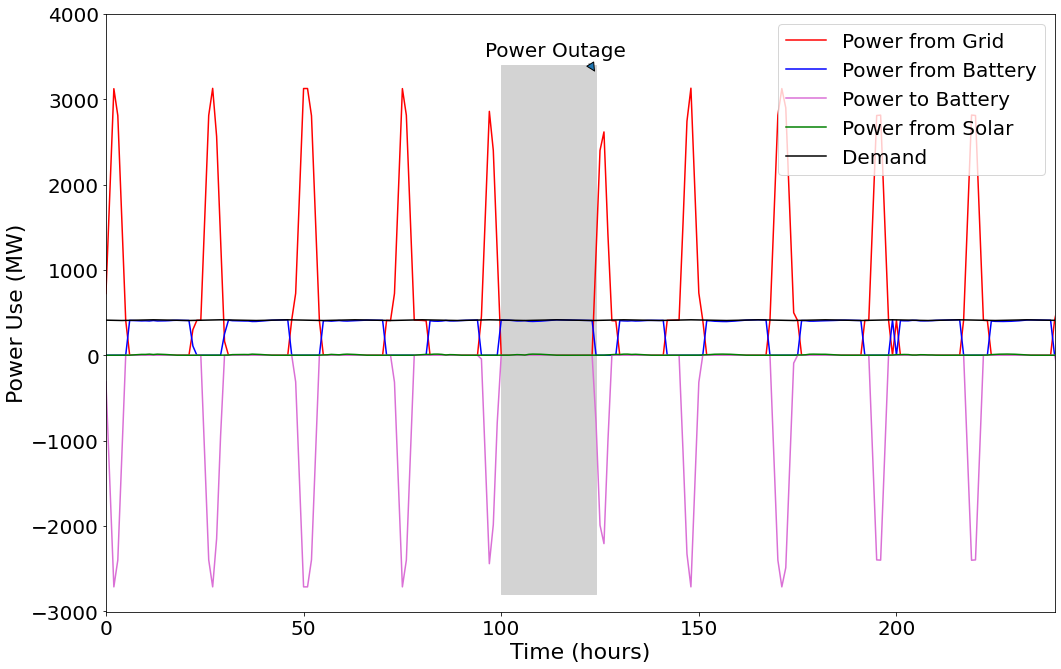

In [29]:
# JUNE 24 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Jun')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 124):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax.plot(range(0,t), P_g.value, color_gridpower, label = 'Power from Grid') 
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery') 
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), P_s*(S_max.value), color_solar, label = 'Power from Solar')
ax.plot(range(0,t), P_L, color_demand, label = 'Demand')
ax.set_yticks([-3000, -2000, -1000, 0, 1000, 2000, 3000, 4000])
ax.add_patch(Rectangle((100,-2800), 24, 6200,color=color_outage))
ax.annotate("Power Outage",
            xy=(124, 3300), xycoords='data',
            xytext=(96, 3500), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
# plt.plot(range(0,t), E_plot, "m", label = 'Battery State of Charge')
ax.legend(['Power from Grid', 'Power from Battery', 'Power to Battery', 'Power from Solar', 'Demand'], loc='upper right')
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power Use (MW)")
ax.set_xlim([0, 240])

# plt.title("24 hour Power Outage (t=100 to t=124): June")

status: optimal
Battery Capacity [MW]:  1826.6666666583787
Minimized Cost: $ 7135478.467450222
Cost of Battery [$]:  1577642.6088041018
Solar Size [kW]:  -3.627246751222731e-05


(0.0, 240.0)

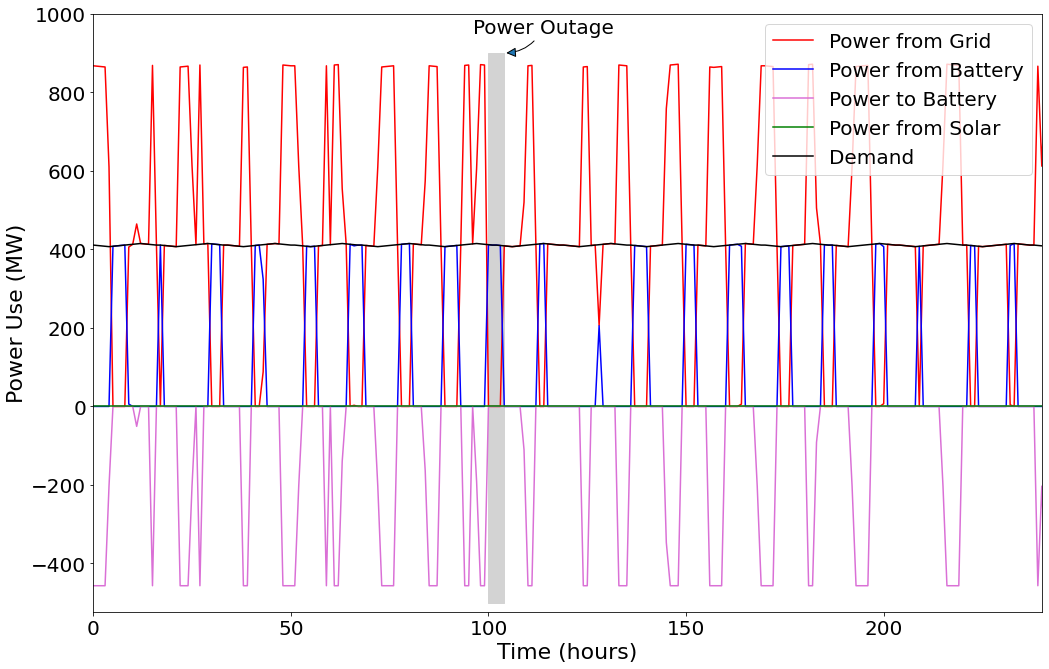

In [31]:
# DEC 4 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Dec')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 104):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax.plot(range(0,t), P_g.value, color_gridpower, label = 'Power from Grid') 
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery') 
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), P_s*(S_max.value), color_solar, label = 'Power from Solar')
ax.plot(range(0,t), P_L, color_demand, label = 'Demand')
ax.set_yticks([-400, -200, 0, 200, 400, 600, 800, 1000])
ax.add_patch(Rectangle((100,-500), 4, 1400,color="lightgray"))
ax.annotate("Power Outage",
            xy=(104, 900), xycoords='data',
            xytext=(96, 950), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
# plt.plot(range(0,t), E_plot, "m", label = 'Battery State of Charge')
ax.legend(['Power from Grid', 'Power from Battery', 'Power to Battery', 'Power from Solar', 'Demand'], loc='upper right')
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power Use (MW)")
ax.set_xlim([0, 240])

# plt.title("4 hour Power Outage (t=100 to t=104): December")

status: optimal
Battery Capacity [MW]:  10860.92336062142
Minimized Cost: $ 14553147.318755738
Cost of Battery [$]:  9380285.838366752
Solar Size [kW]:  20000.000500528102


(0.0, 240.0)

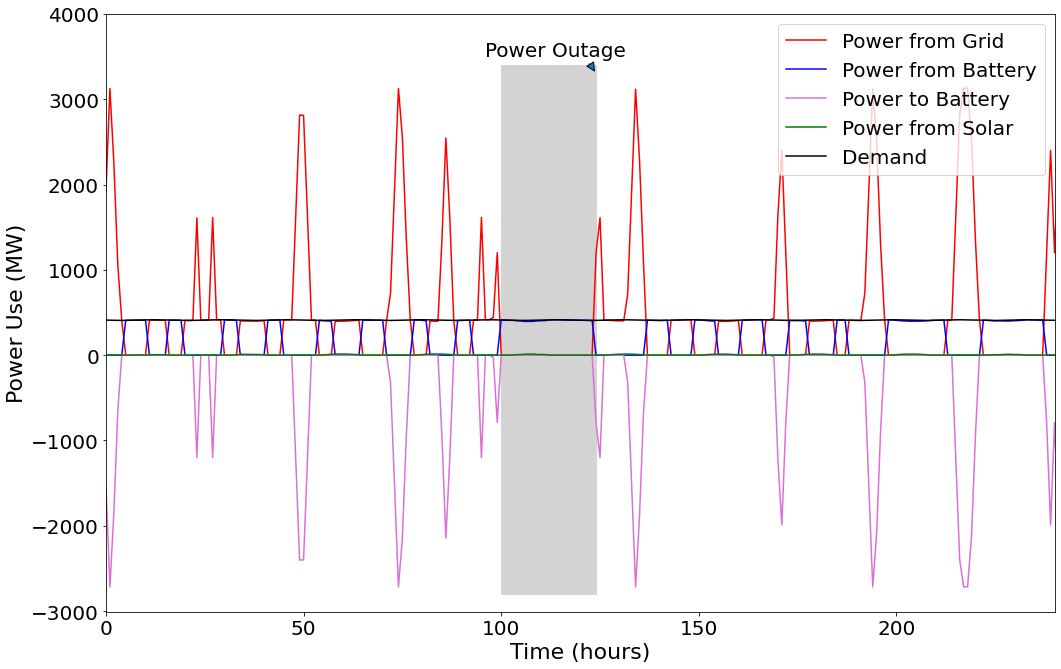

In [30]:
# DEC 24 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Dec')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 124):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax.plot(range(0,t), P_g.value, color_gridpower, label = 'Power from Grid') 
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery') 
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), P_s*(S_max.value), color_solar, label = 'Power from Solar')
ax.plot(range(0,t), P_L, color_demand, label = 'Demand')
ax.set_yticks([-3000, -2000, -1000, 0, 1000, 2000, 3000, 4000])
ax.add_patch(Rectangle((100,-2800), 24, 6200,color=color_outage))
ax.annotate("Power Outage",
            xy=(124, 3300), xycoords='data',
            xytext=(96, 3500), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
# plt.plot(range(0,t), E_plot, "m", label = 'Battery State of Charge')
ax.legend(['Power from Grid', 'Power from Battery', 'Power to Battery', 'Power from Solar', 'Demand'], loc='upper right')
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Power Use (MW)")
ax.set_xlim([0, 240])

# plt.title("24 hour Power Outage (t=100 to t=124): December")

## Battery Plots

status: optimal
Battery Capacity [MW]:  1826.6666666634105
Minimized Cost: $ 6008629.7865555
Cost of Battery [$]:  1577642.6088084478
Solar Size [kW]:  -5.116366492289951e-05


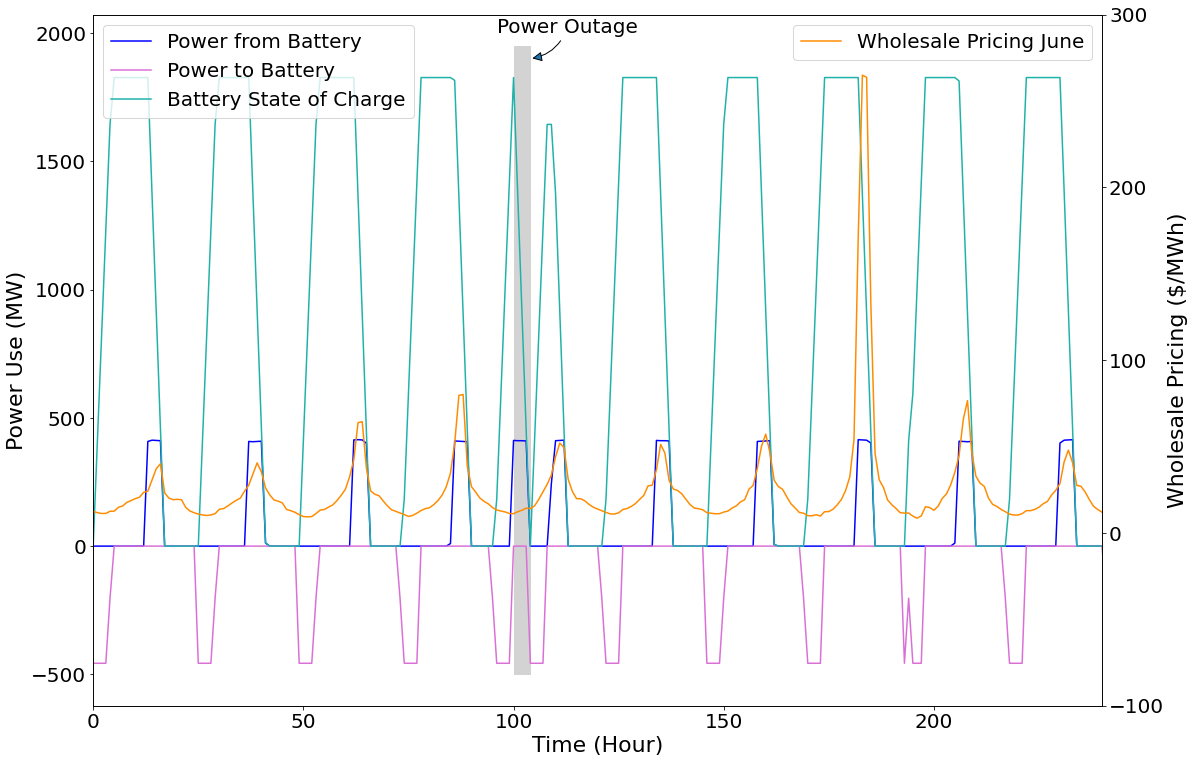

In [32]:
# JUNE 4 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Jun')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 104):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
# ax.set_title('Demand (MW) and Wholesale Pricing ($)')
ax.set_xlabel('Time (Hour)')
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery')
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), E_plot, color_batterystate, label = 'Battery State of Charge')
ax.add_patch(Rectangle((100,-500), 4, 2450,color=color_outage))
ax2.plot(range(0,t), C_j, color_junepricing, label = 'June Pricing')
# ax2.plot(range(0,t), C_d, color_decemberpricing, label = 'December Pricing')
ax.set_ylabel('Power Use (MW)')
ax2.set_ylabel('Wholesale Pricing ($/MWh)')
ax.legend(['Power from Battery', 'Power to Battery', 'Battery State of Charge'], loc='upper left')
ax2.legend(['Wholesale Pricing June'], loc='upper right')
ax2.set_yticks([-100, 0, 100, 200, 300])
# from matplotlib.offsetbox import AnchoredText
# at = AnchoredText(
#     "Power Outage", prop=dict(size=22), frameon=True, loc='upper center')
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# ax.add_artist(at)
ax.annotate("Power Outage",
            xy=(104, 1900), xycoords='data',
            xytext=(96, 2000), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
plt.tight_layout()
plt.xlim([0, 240])
plt.show()
# plt.title("4 hour Power Outage (t=100 to t=104): June")
# leg = plt.legend()

status: optimal
Battery Capacity [MW]:  10856.16336051118
Minimized Cost: $ 12760929.321048295
Cost of Battery [$]:  9376174.754977047
Solar Size [kW]:  20000.00019709498


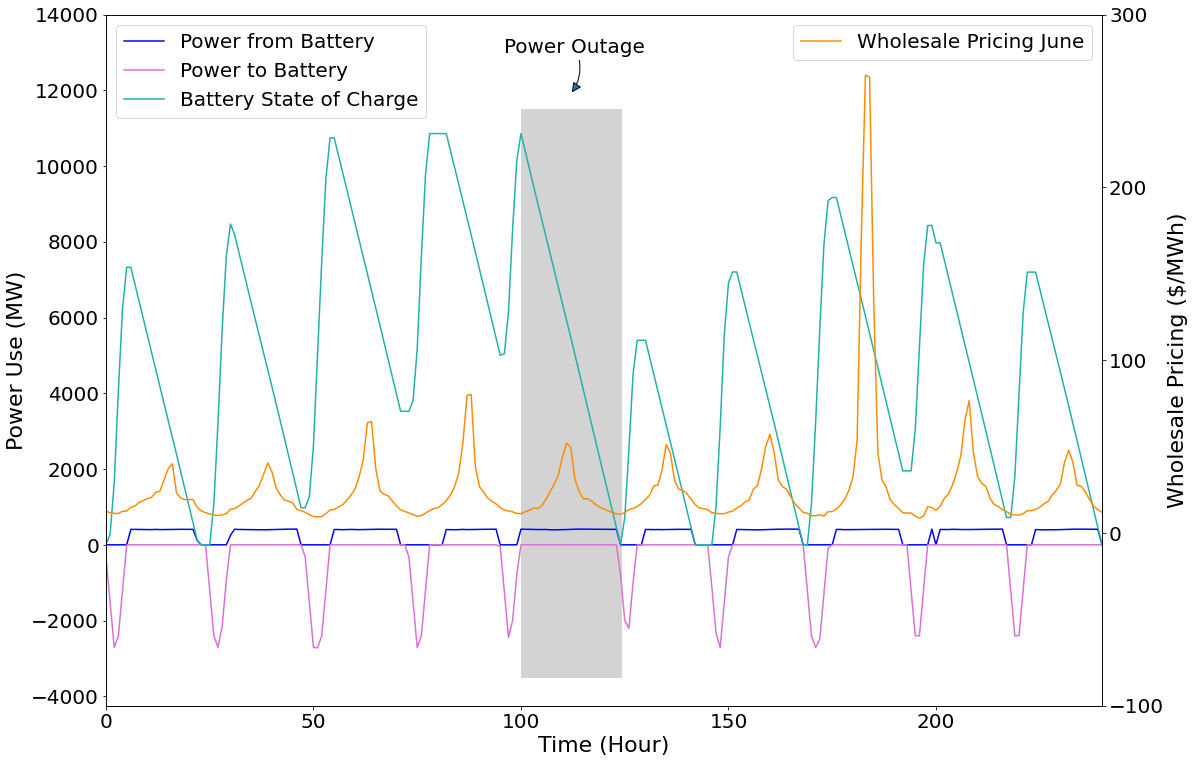

In [33]:
# JUNE 24 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Jun')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='j')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 124):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
# ax.set_title('Demand (MW) and Wholesale Pricing ($)')
ax.set_xlabel('Time (Hour)')
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery')
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), E_plot, color_batterystate, label = 'Battery State of Charge')
ax.add_patch(Rectangle((100,-3500), 24, 15000,color=color_outage))
ax2.plot(range(0,t), C_j, color_junepricing, label = 'June Pricing')
# ax2.plot(range(0,t), C_d, color_decemberpricing, label = 'December Pricing')
ax.set_ylabel('Power Use (MW)')
ax2.set_ylabel('Wholesale Pricing ($/MWh)')
ax.legend(['Power from Battery', 'Power to Battery', 'Battery State of Charge'], loc='upper left')
ax2.legend(['Wholesale Pricing June'], loc='upper right')
ax2.set_yticks([-100, 0, 100, 200, 300])
ax.set_yticks([-4000, -2000, 0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
ax.annotate("Power Outage",
            xy=(112, 11900), xycoords='data',
            xytext=(96, 13000), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
plt.tight_layout()
plt.xlim([0, 240])
plt.show()
# leg = plt.legend()
# plt.title("24 hour Power Outage (t=100 to t=124): June")

status: optimal
Battery Capacity [MW]:  1826.6666666583787
Minimized Cost: $ 7135478.467450222
Cost of Battery [$]:  1577642.6088041018
Solar Size [kW]:  -3.627246751222731e-05


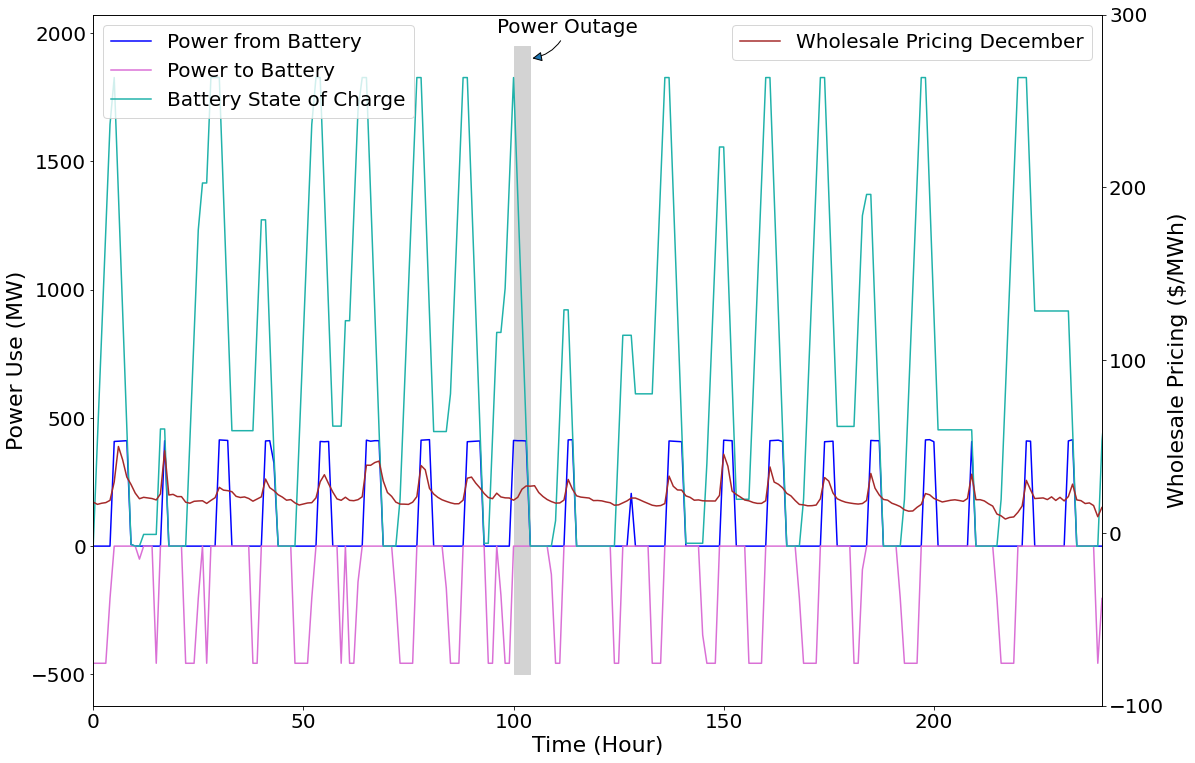

In [36]:
# DEC 4 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Dec')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 104):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
# ax.set_title('Demand (MW) and Wholesale Pricing ($)')
ax.set_xlabel('Time (Hour)')
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery')
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), E_plot, color_batterystate, label = 'Battery State of Charge')
ax.add_patch(Rectangle((100,-500), 4, 2450,color=color_outage))
# ax2.plot(range(0,t), C_j, color_junepricing, label = 'June Pricing')
ax2.plot(range(0,t), C_d, color_decemberpricing, label = 'December Pricing')
ax.set_ylabel('Power Use (MW)')
ax2.set_ylabel('Wholesale Pricing ($/MWh)')
ax.legend(['Power from Battery', 'Power to Battery', 'Battery State of Charge'], loc='upper left')
ax2.legend(['Wholesale Pricing December'], loc='upper right')
ax2.set_yticks([-100, 0, 100, 200, 300])
# from matplotlib.offsetbox import AnchoredText
# at = AnchoredText(
#     "Power Outage", prop=dict(size=22), frameon=True, loc='upper center')
# at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
# ax.add_artist(at)
ax.annotate("Power Outage",
            xy=(104, 1900), xycoords='data',
            xytext=(96, 2000), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
plt.tight_layout()
plt.xlim([0, 240])
plt.show()
# plt.title("4 hour Power Outage (t=100 to t=104): December")

status: optimal
Battery Capacity [MW]:  10860.92336062142
Minimized Cost: $ 14553147.318755738
Cost of Battery [$]:  9380285.838366752
Solar Size [kW]:  20000.000500528102


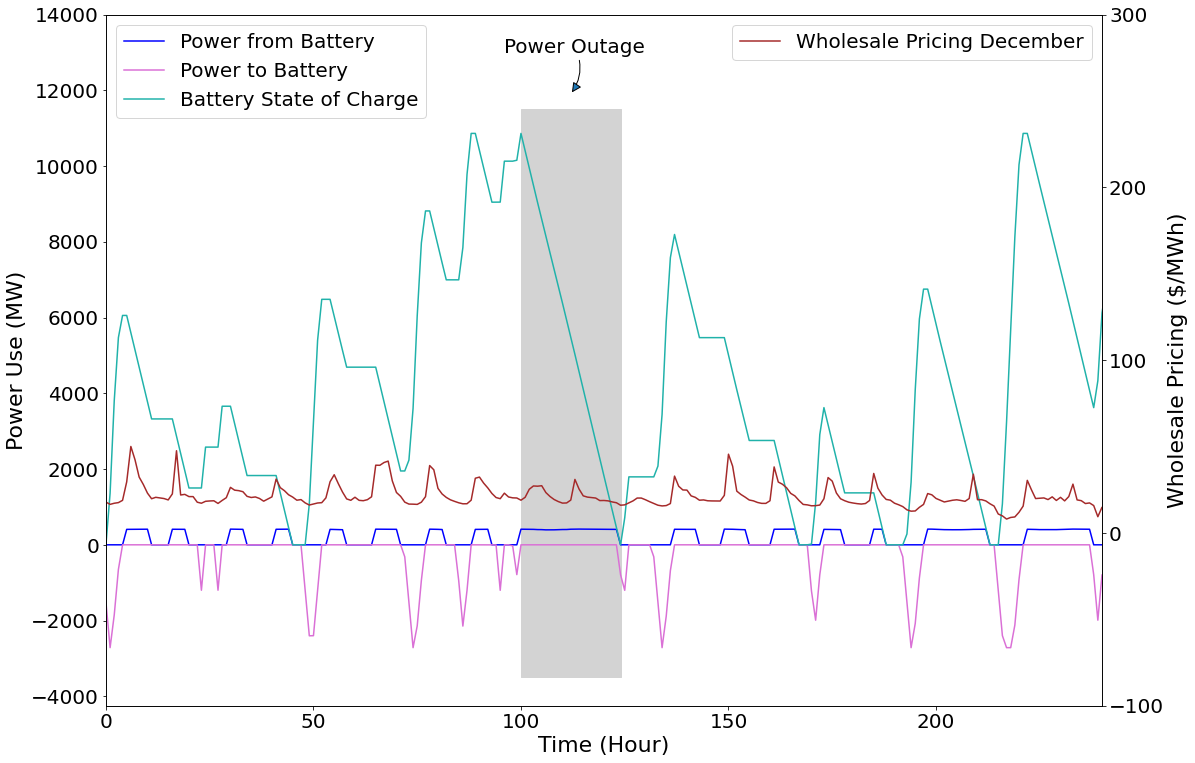

In [34]:
# DEC 24 h

import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# establishing time length (hours)
t = 720 # one month

# establishing load values
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')
P_L = []
for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
#defining ramp values
P_ramp = 20*60 # ~20 MW/min for gas, coal would be ~2 MW/min

# establishing battery capacity (MW) and efficiency
E_max = cp.Variable()
eff = 0.9

# defining battery charge variable
E_b = cp.Variable(t+1)

# defining power draw variables of grid (P_g) and battery (P_ch, P_dis)
P_g = cp.Variable(t)
P_ch = cp.Variable(t) # charge
P_dis = cp.Variable(t) # discharge

# defining cost of power from grid (C_g)
C_g = []
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Dec')
for n in range (0, t):
    C_g = C_g + [df.at[n, "Settlement Point Price"]*(P_g[n])] 
    
# adding in solar
S_max = cp.Variable() #size of the solar panels
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\pvwatts_hourly_Houston_20000kwh.xlsx', sheet_name='d')
P_s = []
for n in range (0, t):
    P_s = P_s + [df.at[n, "ACMW"]] # cost per Mwh of solar
    
# defining battery cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_b_1 = 143000*E_max #cost of battery, assume tax included and maintenance included
fv = C_b_1*((1+i)**m) #future value calculation
C_b = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# defining solar cost
i = 0.04/12 # interest rate per month
m = 20*12 # payback period (months)
C_s_1 = 1000000*0.89*S_max*20 #cost of solar per MW
fv = C_s_1*((1+i)**m) #future value calculation
C_s = fv*(i/(((1+i)**m) - 1))*(1/(1+i)) # monthly payment

# setting up equation to minimize
objective = sum(C_g) + C_b + C_s

# establishing constraints
constraints = []
constraints += [P_g >= 0] # power draw is not negative 
constraints += [P_L == P_g + P_dis + -P_ch + P_s*S_max] # the sources sum to load requirements
constraints += [E_b[0] == 0] # battery charge at start is zero
constraints += [P_ch >= 0] # charge into the is not negative
constraints += [1 >= eff] #efficiency cannot be greater than one
constraints += [P_dis >= 0] # discharge from battery is not negative
constraints += [S_max >= 0] # can't have negative solar capacity
constraints += [S_max <= 1] # solar 20000 kW or less
constraints += [P_dis >= 0] # discharge from battery is not negative
# power outage constraint
for n in range (100, 124):
    constraints += [P_g[n] == 0]
# ramp value constraints - power change between time steps can't exceed ramp limit
for n in range (0, t-1): 
    a = P_g[n]
    b = P_g[n+1]
    constraints += [(a - b) <= P_ramp, (a - b) >= -P_ramp] 
    n+1
for n in range (0, t):
    constraints += [E_max/4 >= P_ch[n]] # battery charge in one time step cannot be greater than the battery capacity
    constraints += [E_max/4 >= P_dis[n]] # battery discharge in one time step cannot be greater than the battery capaticy
for n in range (1, t+1):
    constraints += [E_b[n] == E_b[n-1] + eff*P_ch[n-1] - 1/eff*P_dis[n-1]] 
    # battery effectiveness impacts charge/discharge amounts of battery
for n in range (0, t+1):
    constraints += [E_b[n] >= 0] # battery charge is not negative
    constraints += [E_max >= E_b[n]] # battery charge cannot be greater than the capacity
    
#solving problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve() 

#printing results
print("status:", prob.status)
print("Battery Capacity [MW]: ", E_max.value)
print("Minimized Cost: $", prob.value)
print("Cost of Battery [$]: ", C_b.value)
print("Solar Size [kW]: ", S_max.value*20000)

# battery charge variable for plotting
E_plot = []
for n in range (0, t):
    E_plot = E_plot + [E_b.value[n]]
    
#plotting the results  
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
# ax.set_title('Demand (MW) and Wholesale Pricing ($)')
ax.set_xlabel('Time (Hour)')
ax.plot(range(0,t), P_dis.value, color_batterydischarge, label = 'Power from Battery')
ax.plot(range(0,t), -P_ch.value, color_batterycharge, label = 'Power to Battery')
ax.plot(range(0,t), E_plot, color_batterystate, label = 'Battery State of Charge')
ax.add_patch(Rectangle((100,-3500), 24, 15000,color=color_outage))
# ax2.plot(range(0,t), C_j, color_junepricing, label = 'June Pricing')
ax2.plot(range(0,t), C_d, color_decemberpricing, label = 'December Pricing')
ax.set_ylabel('Power Use (MW)')
ax2.set_ylabel('Wholesale Pricing ($/MWh)')
ax.legend(['Power from Battery', 'Power to Battery', 'Battery State of Charge'], loc='upper left')
ax2.legend(['Wholesale Pricing December'], loc='upper right')
ax2.set_yticks([-100, 0, 100, 200, 300])
ax.set_yticks([-4000, -2000, 0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
ax.annotate("Power Outage",
            xy=(112, 11900), xycoords='data',
            xytext=(96, 13000), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3, rad=-0.3"),
            )
plt.tight_layout()
plt.xlim([0, 240])
plt.show()
# plt.title("24 hour Power Outage (t=100 to t=124): December")

# MISC

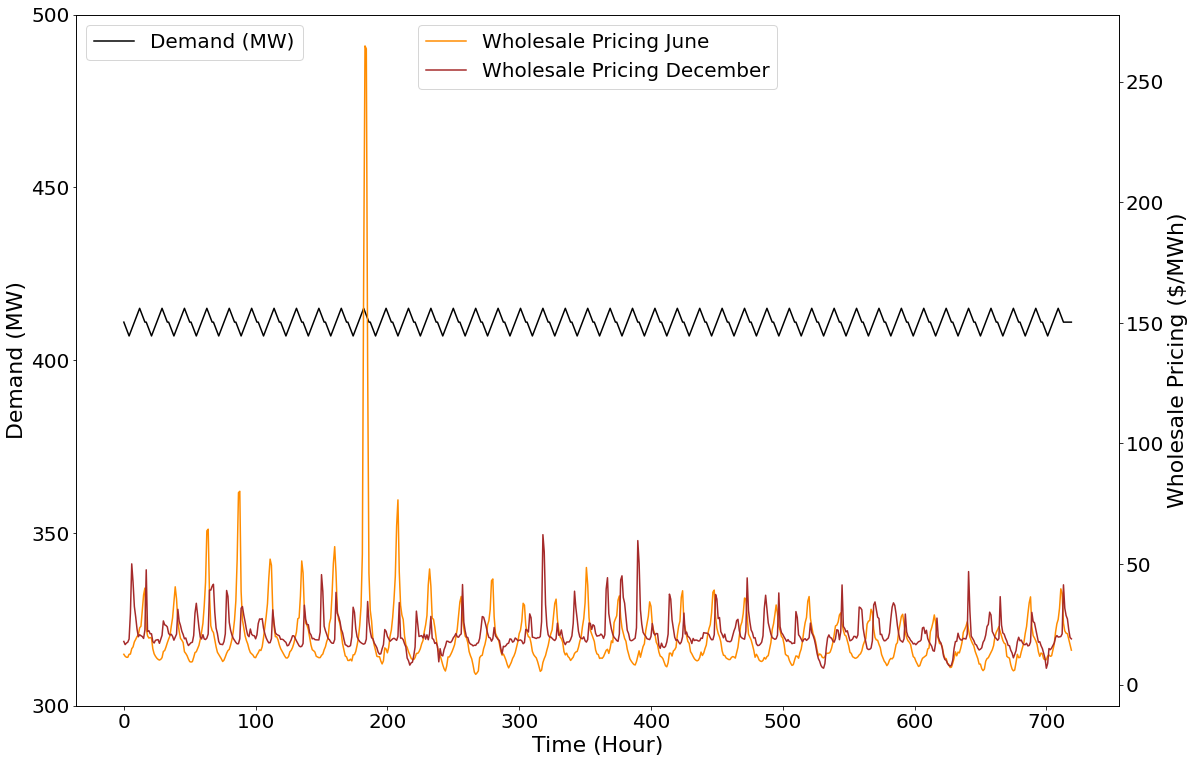

In [26]:
import pandas as pd
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

C_j = []
C_d = []
P_L = []

df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Jun')
for n in range (0, t):
    C_j += [df.at[n, "Settlement Point Price"]] 

df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\houston pricing.xlsx', sheet_name='Dec')
for n in range (0, t):
    C_d += [df.at[n, "Settlement Point Price"]] 
df = pd.read_excel (r'C:\Users\kenda\OneDrive - UCB-O365\Documents\research\ethylene 14.xlsx')

for n in range (0, t):
    P_L = P_L + [df.at[n, 'P_L_s']]
    
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit

fig, ax = plt.subplots(figsize=(17,11))
ax2 = ax.twinx()
# ax.set_title('Demand (MW) and Wholesale Pricing ($)')
ax.set_xlabel('Time (Hour)')
ax.plot(range(0,t), P_L, color_demand, label = 'Demand')
ax2.plot(range(0,t), C_j, color_junepricing, label = 'June Pricing')
ax2.plot(range(0,t), C_d, color_decemberpricing, label = 'December Pricing')
ax.set_ylabel('Demand (MW)')
ax2.set_ylabel('Wholesale Pricing ($/MWh)')
ax.legend(['Demand (MW)'], loc='upper left')
ax2.legend(['Wholesale Pricing June', 'Wholesale Pricing December'], loc='upper center')
ax.set_yticks([300, 350, 400, 450, 500])
# ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
# ax.yaxis.grid(color='lightgray', linestyle='dashed')
plt.tight_layout()
plt.show()